<a href="https://colab.research.google.com/github/AraiKensuke/GCoh/blob/master/simulations/Participant3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Install necessary packages.

In [2]:
#########  clone and install necessary packages from github repositories

import sys
import importlib

if importlib.util.find_spec("GCoh") is None:
  !git clone https://github.com/AraiKensuke/GCoh.git

if importlib.util.find_spec("mne") is None:
  !pip install mne

sys.path.insert(1, "/content/GCoh")    #  add these to searchpath for python modules

# 2)  Upload EEG or multichannel data
Expect a text data file with number of rows = number of temporal observations (ie 500Hz for 10 seconds would have 5000 rows), and number of columns is number of channels.  Click on "Browse" below, pick a file from local disk.  It will be
uploaded to Colab directory, and openned by python.

In [7]:
import numpy as _N
from google.colab import files
uploaded = files.upload()

#  this saves a file of the same name in CWD

keys = list(uploaded.keys())
EEG  = _N.loadtxt(keys[0])     #  this contains multichannel dat    [N_obs x # chs]

Saving Jan012021_03_00_00_artfctrmvd_v1.dat to Jan012021_03_00_00_artfctrmvd_v1.dat


ValueError: ignored

In [8]:
EEG  = _N.loadtxt(keys[0])     #  this contains multichannel dat    [N_obs x # chs]

# 3)  Calculate the GCoh and eigenvectors.  

Here the only thing to that might need to be changed is win and slideby.  Window over which GCoh is calculated, and
how much the window is slid (allows overlapping).  

**Warning, lots of ominmous looking warnings will be printed.  Ignore these**

In [ ]:
import numpy as _N
import scipy.signal as _ssig
import mne.time_frequency as mtf
import mne
import pickle
import sys

import GCoh.chronux_py.chronux_funcs as _chrf
import preprocess_ver

import GCoh.datconfig as datconf
import GCoh.windowed_gcoh as _w_gcoh

dataset =    datconf._RPS    ####  Which data set to use?  
Fs      = 300

#####  These will call up preset values the win, slideby.  Don't have to use these, and
#####  can come up with own.
gcoh_ver    = 5    #  this is a preset one.  
#   wnd, slideby is # of

#  get preset values determined by gcoh_ver.  
#wnd, slideby      = preprocess_ver.get_win_slideby(gcoh_ver)
wnd = 2048
slideby=2048
#  If you know what you're doing, you can use your own.  In general, 
#  for overlapping, its simpler to use wnd some multiple of slideby, like
#  256 and 64.  This will use a window of 256 samples to calculate GCoh, and
#  then move over 64 samples to calculate next GCoh value.  This means 192 
#  samples will be shared between these two calculations, leading to correlation
#  in the GCoh.

rm_chs = []
ch_w_CM, rm_chs, ch_names, ch_types = datconf.getConfig(dataset)

X_cm    = EEG

ch_picks = _N.setdiff1d(ch_w_CM, _N.array(rm_chs))
arr_ch_picks = _N.array(ch_picks)

info = mne.create_info(ch_names=(_N.array(ch_names)[ch_picks]).tolist(), ch_types=(_N.array(ch_types)[ch_picks]).tolist(), sfreq=Fs)

datconf.set_montage(dataset, info)

#####  Calculate GCoh and eigenvectors
dpss_bw=7
f, findx, Ctot, Cvec = _w_gcoh.windowed_gcoh(Fs, wnd, slideby, X_cm, ch_w_CM, ch_picks, info, dpss_bw=dpss_bw)


# 4) Cluster and visualize Eigenvalues

doing GMM
@!!!!! 
(array([0]), array([2]))
manual_clustering   False


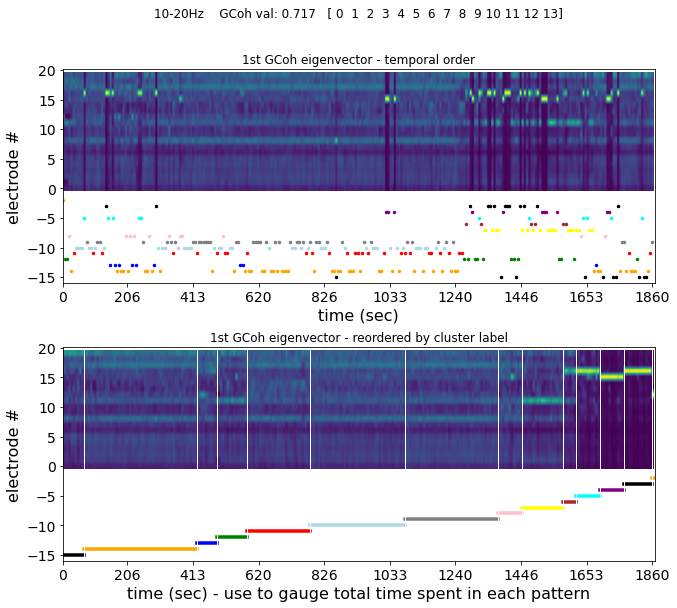

In [20]:
import scipy.stats as _ss
import matplotlib.pyplot as _plt
from sklearn import mixture
from GCoh.eeg_util import unique_in_order_of_appearance, increasing_labels_mapping, rmpd_lab_trnsfrm, find_or_retrieve_GMM_labels, shift_correlated_shuffle, mtfftc
import GCoh.preprocess_ver as _ppv

arr_ch_names = _N.array(ch_names)

ev_n   = 0

win = wnd

_WIDE = 0
_MED  = 1
_FINE = 2
_FINE1 = 3   #



#bin     = 512
#slide   = 64
_WIDE = 0
_FINE = 1

manual_cluster=False

hlfOverlap = int((wnd/slideby)*0.5)

strt       = 0  #  if start at middle of experiment
A_gcoh     = Cvec[strt:]
fs       = f[findx]

imag_evs  = Cvec[strt:, :, ev_n]

L_gcoh  = A_gcoh.shape[0]
nChs    = imag_evs.shape[2]
real_evs  = _N.empty((L_gcoh, fs.shape[0], nChs))



chs = _N.arange(nChs)
ch_names = arr_ch_names[chs].tolist()

for ti in range(L_gcoh):
    real_evs[ti] = _N.abs(imag_evs[ti])

mn = _N.mean(real_evs, axis=0)
sd = _N.std(real_evs, axis=0)


frngs = [10, 20]    ##  frequency ranges (low and high) to look at for clustering.  

ignore_stored = True
pcs     = _N.empty(len(frngs))
####  set range of clusters to look for
minK    =14
maxK    =15

try_Ks  = _N.arange(minK, maxK+1)
#TRs      = _N.array([1, 1, 3, 5, 10, 15, 20, 25, 25])  # more tries for higher K
TRs      = _N.array([1, 15, 20, 25, 25, 30, 40, 50, 60, 60, 60, 60, 60, 60, 80, 80, 80, 80])  # more tries for higher K

bics = _N.ones(((maxK-minK), _N.max(TRs)))*1000000
labs = _N.empty((maxK-minK, _N.max(TRs), real_evs.shape[0]), dtype=_N.int)

nState_start = 0

fL = frngs[0]
fH = frngs[1]

irngs = _N.where((fs > fL) & (fs < fH))[0]
iL    = irngs[0]
iH    = irngs[-1]    

#Apr242020_16_53_03_gcoh_256_64
nStates, rmpd_lab = find_or_retrieve_GMM_labels(None, None, None, real_evs, iL, iH, fL, fH, 1, gcoh_ver, which=0, try_K=try_Ks, TRs=TRs, ignore_stored=ignore_stored, manual_cluster=manual_cluster, do_pca=False, min_var_expld=0.95, dontsave=True)
ps = _N.arange(nStates)
ps += nState_start
nState_start += nStates

#nStates, rmpd_lab = find_or_retrieve_GMM_labels(rpsm[dat], "%(dat)s_gcoh_%(w)d_%(s)d" % {"dat" : dat, "w" : bin, "s" : slide}, real_evs, iL, iH, fL, fH, which=0, try_K=try_Ks, TRs=TRs, log_transform=False)
"""
###############
for K in range(minK, maxK):
    for tr in range(TRs[K]):
        gmm = mixture.GaussianMixture(n_components=K, covariance_type="full")

        gmm.fit(_N.sum(real_evs[:, iL:iH], axis=1))
        bics[K-minK, tr] = gmm.bic(_N.sum(real_evs[:, iL:iH], axis=1))
        labs[K-minK, tr] = gmm.predict(_N.sum(real_evs[:, iL:iH], axis=1))

coords = _N.where(bics == _N.min(bics))
print("min bic %.4e" % _N.min(bics))
bestLab = labs[coords[0][0], coords[1][0]]   #  indices in 2-D array
rmpd_lab = increasing_labels_mapping(bestLab)

nStates =  list(range(minK, maxK))[coords[0][0]]
"""
out_u = _N.mean(real_evs[:, iL:iH], axis=1)
out = _N.empty((L_gcoh, nChs))
iS  = 0
for ns in range(nStates):
    ls = _N.where(rmpd_lab == ns)[0]
    out[iS:iS+len(ls)] = _N.mean(real_evs[ls, iL:iH], axis=1)
    iS += len(ls)

iS = 0
clrs  = ["black", "orange", "blue", "green", "red", "lightblue", "grey", "pink", "yellow", "brown", "cyan", "purple", "black", "orange", "blue", "green", "red", "black", "orange", "blue", "green", "red", "lightblue", "grey", "pink", "yellow", "brown", "cyan", "purple", "black", "orange", "blue", "green", "red"]
W   = L_gcoh
H   = nChs
disp_wh_ratio = 5
aspect = (W/H)/disp_wh_ratio
unit = 2.5
fig = _plt.figure(figsize=(disp_wh_ratio*unit + 1, 3*unit+unit/2))
#   time of middle of window in which GCoh calculated
gcoh_ts = _N.linspace(0, (slideby/Fs)*L_gcoh, L_gcoh, endpoint=False) + (win/2)/Fs
gcoh_bins=_N.arange(L_gcoh)
T_max   = gcoh_ts[-1]
time_at_ticks = _N.array(_N.linspace(0, _N.floor(T_max/10)*10, 10), dtype=_N.int)
bin_at_ticks = _N.interp(time_at_ticks, gcoh_ts, gcoh_bins)

_plt.subplot2grid((2, 1), (0, 0))        
_plt.title("1st GCoh eigenvector - temporal order")
#fig.add_subplot(nStates+2, 1, 1)  
_plt.imshow(out_u.T, aspect=aspect)
_plt.ylim(-(nStates+2), nChs+0.1)
for ns in range(nStates):
    nsx = _N.where(rmpd_lab == ns)[0]
    _plt.scatter(nsx, _N.ones(len(nsx))*ns - nStates - 1, color=clrs[ns], lw=1.5, s=4)
_plt.xlim(0, L_gcoh)
_plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
_plt.ylabel("electrode #", fontsize=16)
_plt.xlabel("time (sec)", fontsize=16)
_plt.xticks(bin_at_ticks, time_at_ticks, fontsize=14)
_plt.yticks(fontsize=14)

_plt.subplot2grid((2, 1), (1, 0))        
_plt.title("1st GCoh eigenvector - reordered by cluster label")
#fig.add_subplot(nStates+2, 1, 1)    
_plt.imshow(out.T, aspect=aspect)
_plt.ylim(-(nStates+2), nChs+0.1)
for ns in range(nStates):
    ls = _N.where(rmpd_lab == ns)[0]
    liS = iS
    iS += len(ls)
    _plt.plot([liS, iS], [ns-nStates-1, ns-nStates-1], color=clrs[ns], lw=3.5)
    if ns < nStates-1:
        _plt.axvline(x=iS, color="white", lw=1)
_plt.xlim(0, L_gcoh)
_plt.suptitle("%(1)d-%(2)dHz    GCoh val: %(gcoh).3f   %(sts)s" % {"1" : fL, "2" : fH, "gcoh" : _N.mean(Ctot[:, irngs]), "sts" : str(ps)})
_plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
_plt.ylabel("electrode #", fontsize=16)
_plt.xlabel("time (sec) - use to gauge total time spent in each pattern", fontsize=16)
_plt.xticks(bin_at_ticks, time_at_ticks, fontsize=14)
_plt.yticks(fontsize=14)

iS = 0
for ns in range(nStates):
    ls = _N.where(rmpd_lab == ns)[0]
    iS += len(ls)
    if ns < nStates-1:
        _plt.axvline(x=iS, color="white", lw=1)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, hspace=0.3)
